# EDA Milestone

Name: Isha Kashyap

Date: 14-07-2024

Github link: https://github.com/ishakashyap/spotting-toxic-clouds-thesis

For my thesis, my task is to perform a self-supervised learning method on videos of factory emissions to classify whether or not there are toxic emissions visibly present in the videos.

This notebook contains code to visualize data and understand it better. Since I am performing a self-supervised learning task on this data, I do not have labels of my training data and therefore cannot say anything about the distribution of the labels. Instead, I will show how the data augmentation works and what is being input into the models. For my classification task, I will show the distribution of the labels retrieved from the metadata file.

I currently have 20.000 unlabeled videos and 12.567 labeled videos of factories provided by Project RISE initiated by the CMU Create Lab, whom collected videos from volunteers. These videos are all 3 second-long videos of factory emissions all with 180x180 resolution. Some do not have any emissions in them, some have hydrogen and toxic emissions in them and some only one of the two. 

Below you can find how one frame can be transformed to help make the features of the data more generalizable.

Project RISE data can be found in their GitHub: https://github.com/CMU-CREATE-Lab/deep-smoke-machine

In [15]:
import os
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Here I present 4 frames with either smoke, steam, both or neither

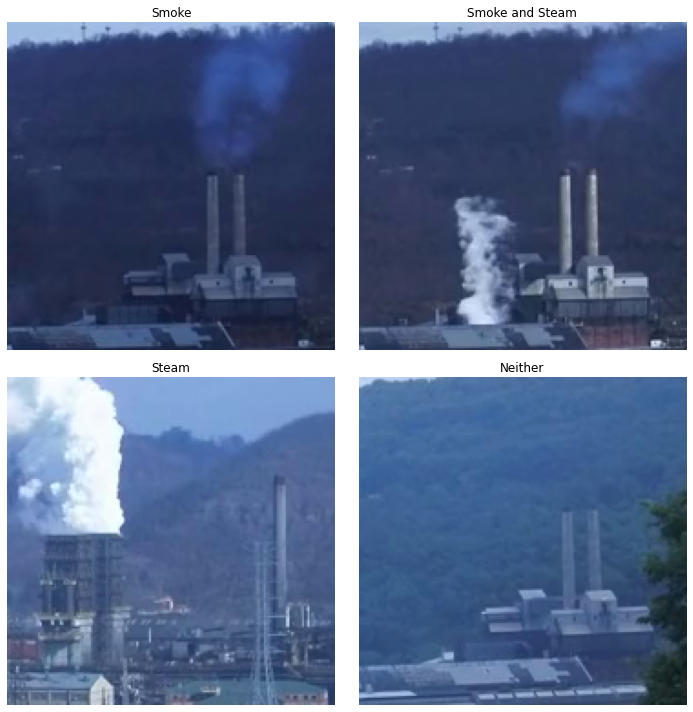

In [60]:
# Path to the folder containing the videos
folder_path = "./train_set"

# List of specified video files
video_files = [
    "0-0-2019-01-11-6304-884-6807-1387-180-180-6307-1547228230-1547228405.mp4",
    "0-0-2019-01-11-6304-884-6807-1387-180-180-6991-1547231655-1547231830.mp4",
    "0-10-2018-12-11-2583-1011-3086-1514-180-180-5528-1544543855-1544544030.mp4",
    "0-0-2018-06-11-6304-964-6807-1467-180-180-5450-1528722020-1528722195.mp4"
]

# List to store the frames
frames = []

# Read one frame from each specified video
for video_file in video_files:
    video_path = os.path.join(folder_path, video_file)
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    cap.release()
    if success:
        # Convert BGR to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)
        frames.append(frame_pil)

# Create a 2x2 grid to display the frames
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate through the frames and plot them
for i, ax in enumerate(axs.flat):
    if i < len(frames):
        ax.imshow(frames[i])
        if i == 0:
            ax.set_title("Smoke")
        elif i == 1:
            ax.set_title("Smoke and Steam")
        elif i == 2:
            ax.set_title("Steam")
        else:
            ax.set_title("Neither")
    ax.axis('off')

# Display the grid of frames
plt.tight_layout()
plt.show()


In this example I take one video from my data and read one frame.

In [93]:
# Read the data from the filepath
cap = cv2.VideoCapture("train_set/0-0-2018-06-11-6304-964-6807-1467-180-180-5450-1528722020-1528722195.mp4")
success, frame = cap.read()
cap.release()
if success:
    # Convert BGR to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame_rgb)

For my transformations I resize the data, perform a Gaussian blur, Color jitter, Grayscale, Horizontal flip, Random rotation and Center crop. I finally transform my frame to a tensor and normalize it to make the eventual training process more stable, but this can be ignored for now.

In [101]:
# Add the transformation tasks
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [102]:
transformed_frame = transform(frame)


Now we plot the before and after of the frame. Every time this transformation is run, the results will be different due to the randomness of some of the transformations.

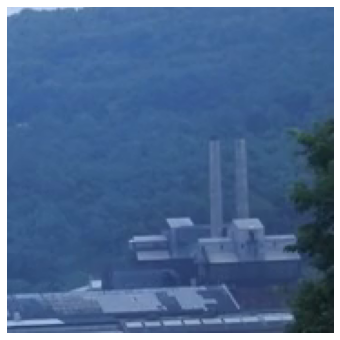

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(frame)  # Unnormalize
ax.axis('off')
plt.show()

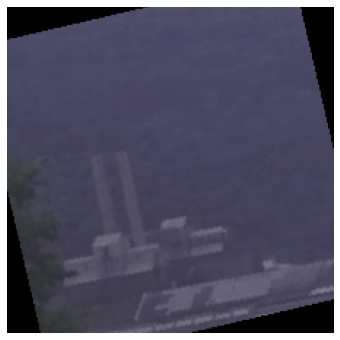

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(transformed_frame.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize
ax.axis('off')
plt.show()

# Distribution of labels

Below, I will visualize the distribution of the labels for my classification task. For this, I will use a metadata file that matches the video files with their respective labels (also provided by Project RISE).

In [42]:
import json
from collections import Counter

with open('./metadata_02242020.json', 'r') as file:
    json_data = json.load(file)

label_state_admin_values = [item["label_state_admin"] for item in json_data]

distribution = Counter(label_state_admin_values)

print(len(json_data))
print(distribution)

12567
Counter({16: 5642, 23: 4365, -1: 2560})


12567
Counter({16: 5642, 23: 4365, -1: 2560})


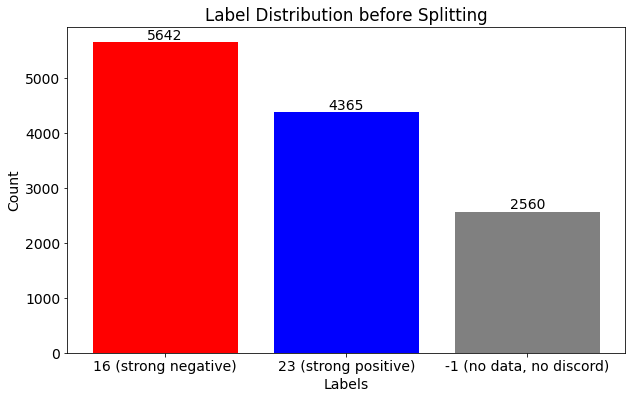

In [13]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# Load JSON data
with open('./metadata_02242020.json', 'r') as file:
    json_data = json.load(file)

# Extract label values
label_state_admin_values = [item["label_state_admin"] for item in json_data]

# Calculate the distribution
distribution = Counter(label_state_admin_values)

# Print the total number of entries and the distribution
print(len(json_data))
print(distribution)

# Plotting
labels = ['16 (strong negative)', '23 (strong positive)', '-1 (no data, no discord)']
counts = [distribution[16], distribution[23], distribution[-1]]
colors = ['red', 'blue', 'grey']  # List of colors for each bar

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(labels, counts, color=colors)

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

# Set plot title and labels
ax.set_title('Label Distribution before Splitting')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')

# Display the plot
plt.show()


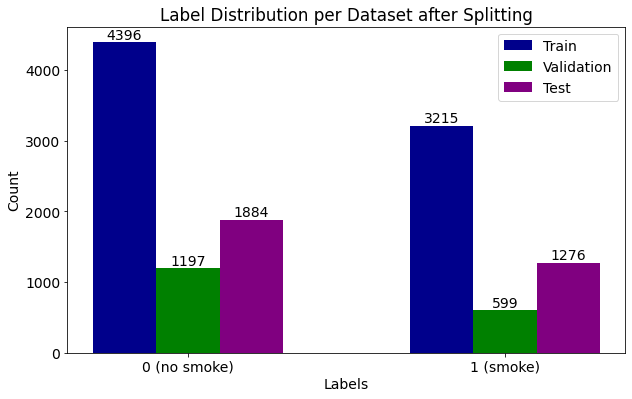

Train - Total number of entries: 7611
Train - Distribution: Counter({0: 4396, 1: 3215})
Validation - Total number of entries: 1796
Validation - Distribution: Counter({0: 1197, 1: 599})
Test - Total number of entries: 3160
Test - Distribution: Counter({0: 1884, 1: 1276})


In [16]:
# Define the paths to your JSON files
json_files = {
    'Train': './split/metadata_train_split_by_date.json',
    'Validation': './split/metadata_validation_split_by_date.json',
    'Test': './split/metadata_test_split_by_date.json'
}

# Initialize a dictionary to hold distributions for each dataset
distributions = {}

# Iterate over each JSON file
for dataset_name, json_file in json_files.items():
    with open(json_file, 'r') as file:
        json_data = json.load(file)
    
    # Extract label values
    label_values = [item["label"] for item in json_data]
    
    # Calculate the distribution
    distribution = Counter(label_values)
    distributions[dataset_name] = distribution

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each dataset
colors = ['darkblue', 'green', 'purple']

# Plot the distribution for each dataset
bar_width = 0.2
positions = np.arange(len(next(iter(distributions.values()))))  # assuming all distributions have the same keys
shift = 0

label_mapping = {0: "0 (no smoke)", 1: "1 (smoke)"}

for (dataset_name, distribution), color in zip(distributions.items(), colors):
    labels, counts = zip(*sorted(distribution.items()))
    labels = [label_mapping[label] for label in labels]  # Map labels to new names
    bar_positions = positions + shift
    bars = ax.bar(bar_positions, counts, width=bar_width, label=dataset_name, color=color)
    
    # Add text annotations
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')
    
    shift += bar_width

# Set plot title and labels
ax.set_title('Label Distribution per Dataset after Splitting')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.legend()

# Display the plot
plt.xticks(positions + bar_width, sorted(label_mapping.values()))
plt.show()

# Print the total number of entries and the distributions for verification
for dataset_name, distribution in distributions.items():
    print(f"{dataset_name} - Total number of entries: {sum(distribution.values())}")
    print(f"{dataset_name} - Distribution: {distribution}")

### Check for overlap

In [104]:
import os

# Paths to the folders containing the videos
folder_paths = [
    "./full_dataset",
    "./train_set",
    "./test_set",
    "./validation_set"
]

# Dictionary to store filenames and their occurrences
filename_dict = {}

# Iterate over each folder
for folder_path in folder_paths:
    # Get a list of all video files in the folder
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    # Add filenames to the dictionary with occurrence count
    for video_file in video_files:
        if video_file in filename_dict:
            filename_dict[video_file].append(folder_path)
        else:
            filename_dict[video_file] = [folder_path]

# Find overlapping filenames
overlapping_filenames = {file: paths for file, paths in filename_dict.items() if len(paths) > 1}

# Print the overlapping filenames and the folders they are found in
for filename, folders in overlapping_filenames.items():
    print(f"Filename: {filename}")
    print(f"Found in folders: {', '.join(folders)}\n")

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10058-1528745070-1528745245.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10130-1528745430-1528745605.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10310-1528746330-1528746505.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10346-1528746510-1528746685.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10454-1528747050-1528747225.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10670-1528748130-1528748305.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10778-1528748670-1528748845.mp4
Found in folders: ./full_dataset, ./train_set

Filename: 0-0-2018-06-11-6304-964-6807-1467-180-180-10850-1528749030-1528749205.mp4

Check how many there are

In [107]:
len(overlapping_filenames)

5624